Importing dependencies

In [25]:
import time
import pytz
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import date, timedelta

Testing out the API output

In [26]:
result = requests.get('https://api.meteo.lt/v1/stations/kauno-ams/observations/2024-12-19')
print("JSON data:")
print(result.json())

JSON data:
{'station': {'code': 'kauno-ams', 'name': 'Kauno AMS', 'coordinates': {'latitude': 54.88396, 'longitude': 23.83588}}, 'observations': [{'observationTimeUtc': '2024-12-19 00:00:00', 'airTemperature': 5.6, 'feelsLikeTemperature': 1.8, 'windSpeed': 5.5, 'windGust': 11.1, 'windDirection': 231, 'cloudCover': 100, 'seaLevelPressure': 1002.7, 'relativeHumidity': 97, 'precipitation': 0.4, 'conditionCode': 'light-rain'}, {'observationTimeUtc': '2024-12-19 01:00:00', 'airTemperature': 5.7, 'feelsLikeTemperature': 2.5, 'windSpeed': 4.3, 'windGust': 7.7, 'windDirection': 226, 'cloudCover': 100, 'seaLevelPressure': 1002, 'relativeHumidity': 97, 'precipitation': 0.5, 'conditionCode': 'light-rain'}, {'observationTimeUtc': '2024-12-19 02:00:00', 'airTemperature': 6, 'feelsLikeTemperature': 2.8, 'windSpeed': 4.5, 'windGust': 9, 'windDirection': 226, 'cloudCover': 100, 'seaLevelPressure': 1001.4, 'relativeHumidity': 97, 'precipitation': 0.3, 'conditionCode': 'light-rain'}, {'observationTimeUt

The API data class for geting weather forecasts and historic data

In [27]:
"""
Naudojami tryskintamieji:
location - lokacijos kodas
station - metorologinės stotelės kodas
url - Meteo.lt API URL adresas

Orų prognozėms naudojamas location, istoriniams duomenims station.
Šie du kintamieji neturi jokių bendrų parametrų, kurie gali būti gauti per API užklausą,
dėl to nuspręndžiau vietovės parametrą iškirsti į du atskirus.
"""
class APIData():
    def __init__(self, location: str, station:str, url: str):
        self.location: str = location
        self.station: str = station
        self.url: str = url

    def historicData(self, timeFrom: date, timeTo: date):
        # Patikriname ar laikas iki yra ne ateityje, kadangi ateityje nėra istorinių įrašų, 
        # kuriuos būtų galima gauti per API
        if timeTo <= date.today():
            timeCurrent = timeFrom
            df = pd.DataFrame(columns = ['observationTimeUtc', 'airTemperature', 'relativeHumidity'])
            df["observationTimeUtc"] = pd.to_datetime(df["observationTimeUtc"])

            # Kadangi API gali gražinti tik specifinės dienos įrašus, sukame while ciklą,
            # kol į pandas.Dataframe bus pridėti visų dienų įrašai
            while timeCurrent <= timeTo:
                result = requests.get(f'{self.url}/stations/{self.station}/observations/{timeCurrent}')
                new_data = pd.DataFrame(result.json()['observations'])
                new_data["observationTimeUtc"] = pd.to_datetime(new_data["observationTimeUtc"])

                df = pd.concat([df, new_data], ignore_index=True)
                timeCurrent = timeCurrent + timedelta(days=1)
                time.sleep(0.5) # Kas API užklausą užmigdome ciklą pusei sekundės, kad išvengtume API limitų (maksimaliai galima daryt 180 užklausų per minutę)
            
            # Įrašo laiką paverčiame duomenų rinkinio indeksu, jam sureguliuojame laiko zoną
            df.set_index("observationTimeUtc", inplace=True)
            df.index = df.index.tz_localize("UTC")
            df.index = df.index.tz_convert("Europe/Vilnius")
            return df
        
        else:
            return('The specified time (timeTo) is later than the current time!')
        
    def forecastData(self):
        # Orų prognozės API vienų atsaku grąžina visą galimą informaciją, dėl to nesiunčiame papildomų užklausų
        result = requests.get(f'{self.url}/places/{self.location}/forecasts/long-term')
        df = pd.DataFrame(result.json()['forecastTimestamps'])
        df["forecastTimeUtc"] = pd.to_datetime(df["forecastTimeUtc"])

        # Įrašo laiką paverčiame duomenų rinkinio indeksu, jam sureguliuojame laiko zoną
        df.set_index("forecastTimeUtc", inplace=True)
        df.index = df.index.tz_localize("UTC")
        df.index = df.index.tz_convert("Europe/Vilnius")
        return df

Creating the API Data object

In [28]:
api = APIData(location = 'kaunas', station = 'kauno-ams', url = 'https://api.meteo.lt/v1')

Return historic forecast data for last year and all possible future predictions

In [29]:
dfHistoric: pd.DataFrame = api.historicData(timeFrom = date.today() - timedelta(days=365), timeTo = date.today())
dfForcast: pd.DataFrame = api.forecastData()

Checking out returned dataframes

In [30]:
dfHistoric

,airTemperature,relativeHumidity,feelsLikeTemperature,windSpeed,windGust,windDirection,cloudCover,seaLevelPressure,precipitation,conditionCode
observationTimeUtc,,,,,,,,,,
2023-12-20 02:00:00+02:00,5.7,96,2.3,4.8,9.2,263.0,100.0,1002.0,0.1,light-rain
2023-12-20 03:00:00+02:00,5.6,95,2.1,4.9,8.6,260.0,100.0,1001.5,0.0,light-rain
2023-12-20 04:00:00+02:00,5.5,95,2.3,4.2,8.4,295.0,100.0,1001.4,0.1,light-rain
2023-12-20 05:00:00+02:00,4.3,96,1.5,3.2,7.3,306.0,100.0,1001.6,0.3,light-rain
2023-12-20 06:00:00+02:00,4.1,94,1.9,2.4,6.5,271.0,100.0,1001.6,0.1,rain
...,...,...,...,...,...,...,...,...,...,...
2024-12-19 13:00:00+02:00,8.7,88,5.7,5.6,9.3,218.0,100.0,997.6,0.0,cloudy
2024-12-19 14:00:00+02:00,8.5,88,5.1,6.5,9.5,214.0,100.0,996.5,0.0,cloudy
2024-12-19 15:00:00+02:00,8.7,86,5.0,7.8,11.6,216.0,100.0,995.8,0.0,cloudy


In [31]:
dfForcast

,airTemperature,feelsLikeTemperature,windSpeed,windGust,windDirection,cloudCover,seaLevelPressure,relativeHumidity,totalPrecipitation,conditionCode
forecastTimeUtc,,,,,,,,,,
2024-12-19 16:00:00+02:00,9.0,6.0,6,11,193,100,995,85,0.0,cloudy
2024-12-19 17:00:00+02:00,8.8,5.7,6,11,196,100,995,83,0.0,cloudy
2024-12-19 18:00:00+02:00,8.5,5.3,6,11,206,100,994,83,0.0,cloudy
2024-12-19 19:00:00+02:00,7.8,4.8,5,11,207,100,994,89,0.5,rain
2024-12-19 20:00:00+02:00,7.4,4.3,5,11,202,100,993,93,0.8,rain
...,...,...,...,...,...,...,...,...,...,...
2024-12-25 14:00:00+02:00,-0.2,-2.7,2,5,350,91,1035,88,0.0,cloudy
2024-12-25 20:00:00+02:00,-1.4,-1.4,1,5,4,100,1037,95,0.0,cloudy
2024-12-26 02:00:00+02:00,-1.0,-1.0,1,3,333,100,1039,97,0.0,cloudy


Calculating the themperature and humidity means from historic data

In [32]:
# Kadangi duomenys saugomi pandas.Dataframe tiesiog naudojau pacios pandas bibliotekos metodus
print('average historic temparature for past year:')
print(dfHistoric['airTemperature'].mean())
print('\naverage historic humidity for past year:')
print(dfHistoric['relativeHumidity'].mean())

average historic temparature for past year:
9.771456244302644

average historic humidity for past year:
78.46422060164083


Calculating average historic day and night temperatur for last year

In [33]:
# Iš istorinių duomenų rinkinio susikūriau du atskirus naujus pandas.Dataframe objektus, kur panaudojau filtravimą
dfHistDay: pd.DataFrame = dfHistoric[(dfHistoric.index.hour >= 8) & (dfHistoric.index.hour <= 20)]
dfHistNight: pd.DataFrame = dfHistoric.drop(index = dfHistDay.index)

print('average historic day temparature for past year:')
print(dfHistDay['airTemperature'].mean())
print('\naverage historic night temparature for past year:')
print(dfHistNight['airTemperature'].mean())

average historic day temparature for past year:
11.262208201892744

average historic night temparature for past year:
8.008579955235016


Calculating how many weekends had some sort of rain forecast for last year

In [34]:
# Pirma pašaliname visus įrašus kurie yra ne šeštadienis/sekmadienis
dfHistWeekend = dfHistoric[dfHistoric.index.weekday >= 5]
dfHistWeekend.loc[:, ('week')] = dfHistWeekend.index.to_period('W-SUN') # Sugrupuojame visus įrašus savaitėmis
# Kadangi užduotyje nebuvo parašyta kokio tiksliai lietaus ieškome, iš visų galimų orų kategorijų tiesiog ieškau visų kur vyksta koks nors lietus
# Sukuriamas naujas duomenų rinkinys (pandas.Series), kur raktinė reikšmė yra savitės ribos (visos 7 dienos, tačiau atrinkimas buvo daromas tik savaitgaliams),
# o saugoma reikšmė yra arba 0 (lietaus nebuvo), arba 1 (lyjo)
weatherChecks =  ['light-rain', 'rain', 'heavy-rain', 'isolated-thunderstorms', 'thunderstorms', 'heavy-rain-with-thunderstorms']
rainCheck = dfHistWeekend.groupby('week')['conditionCode'].apply(lambda x: any(condition in x.values for condition in weatherChecks)).astype(int)
dfWeekendRain = pd.DataFrame(rainCheck)
dfWeekendRain.columns = ['rainOccured']

# Galiausiai atvaizduojame rezultatą. Atvaizdavau iš kiek savaičių lyjo, patikrinti ar buvo teisingai sugrupuotos dienos (Metai turėtų turėti 52 savaitgalius)
print('number of weekends where some kind of rain occured for past year')
rainNum = dfWeekendRain['rainOccured'].sum()
dfRainLen = len(dfWeekendRain)
print(f'{rainNum} / {dfRainLen}\n\n')

number of weekends where some kind of rain occured for past year
36 / 52




C:\Users\Vartotojas1\AppData\Local\Temp\ipykernel_17428\2378777888.py:3: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  dfHistWeekend.loc[:, ('week')] = dfHistWeekend.index.to_period('W-SUN') # Sugrupuojame visus įrašus savaitėmis
C:\Users\Vartotojas1\AppData\Local\Temp\ipykernel_17428\2378777888.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfHistWeekend.loc[:, ('week')] = dfHistWeekend.index.to_period('W-SUN') # Sugrupuojame visus įrašus savaitėmis


Geting temperatures for last week and future forecasts

In [35]:
currentTime = pd.Timestamp.now(tz=dfHistoric.index.tz)
lastWeekTime = currentTime - pd.DateOffset(weeks=1)
dfHistWeek = dfHistoric[dfHistoric.index >= lastWeekTime]

histTemperature = dfHistWeek['airTemperature']
futureTemperature = dfForcast['airTemperature']

Ploting the temperatures

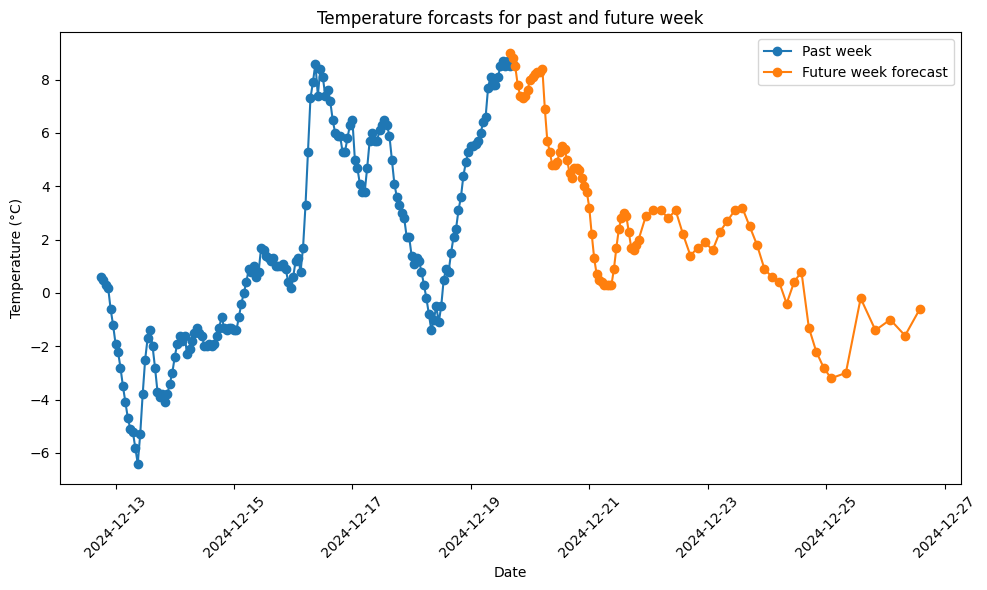

In [36]:
# Naudojau matplotlib.pyplot, nes nebuvo specifinių reikalavimų su kuo atvaizduoti
plt.figure(figsize=(10, 6))
plt.plot(histTemperature, label="Past week", marker='o')
plt.plot(futureTemperature, label="Future week forecast", marker='o')

plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.title('Temperature forcasts for past and future week')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

The method for interpolating temperatures

In [37]:
# pandas biblioteka turi savo interpoliacijos funkcijas, dėl to tiesiog panaudojau jau ten egzistuojančią
def resample(temperatures: pd.Series) -> pd.Series :
    newTemperatures = temperatures.resample('5T').interpolate(method='linear')
    return newTemperatures

Testing Interpolation

In [38]:
# Kad nebūtų labai daug temperatūrų taškų per naujo išsitraukiau tik šendienos temperatūras ir interpoliacijas darau su jomis
dfToday = api.historicData(timeFrom = date.today(), timeTo = date.today())
hourlyTemperature = dfToday['airTemperature']
minuteTemperature = resample(temperatures = hourlyTemperature)

Printing out results to check, if the temperature was interpolated every 5 minutes

In [16]:
print(minuteTemperature)

observationTimeUtc
2024-12-19 02:00:00+02:00    5.600000
2024-12-19 02:05:00+02:00    5.608333
2024-12-19 02:10:00+02:00    5.616667
2024-12-19 02:15:00+02:00    5.625000
2024-12-19 02:20:00+02:00    5.633333
                               ...   
2024-12-19 15:40:00+02:00    8.566667
2024-12-19 15:45:00+02:00    8.550000
2024-12-19 15:50:00+02:00    8.533333
2024-12-19 15:55:00+02:00    8.516667
2024-12-19 16:00:00+02:00    8.500000
Freq: 5T, Name: airTemperature, Length: 169, dtype: float64


Ploting result

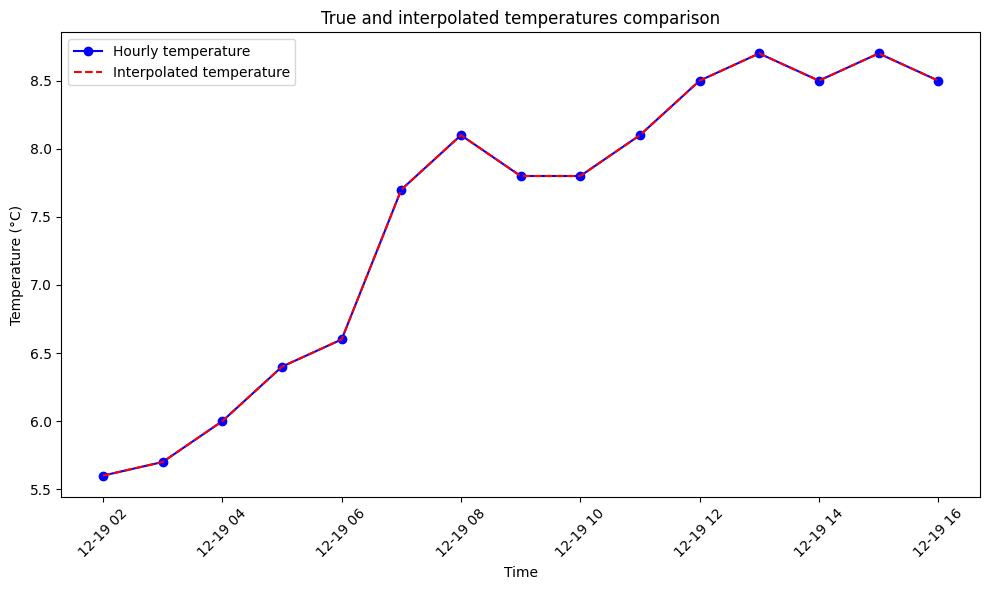

In [ ]:
# Su matplotlib.pyplot atvaizdavau tikrą ir interpoliuotas temperatūras, kad pamatyčiau ar skaičiavimai buvo atlikti teisingai
plt.figure(figsize=(10, 6))
plt.plot(hourlyTemperature, label='Hourly temperature', marker='o', color='blue')
plt.plot(minuteTemperature, label='Interpolated temperature', linestyle='--', color='red')

plt.xlabel('Time')
plt.ylabel('Temperature (°C)')
plt.title('True and interpolated temperatures comparison')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()